In [1]:
# libraries loading

import numpy as np # linear algebra
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# 1-) Data Inspection 

In [4]:
# import dataset 

data_train = pd.read_csv("C:/Users/mayen/ML_DL_PROJECTS/CARS_PRICES/data/raw_data/train-data.csv")
data_test = pd.read_csv("C:/Users/mayen/ML_DL_PROJECTS/CARS_PRICES/data/raw_data/test-data.csv")

print("data_train shape : ", data_train.shape)
print("data_test shape : ", data_test.shape)
data_train.head()

data_train shape :  (6019, 14)
data_test shape :  (1234, 13)


,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [4]:
# info
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage            6017 non-null   object 
 9   Engine             5983 non-null   object 
 10  Power              5983 non-null   object 
 11  Seats              5977 non-null   float64
 12  New_Price          824 non-null    object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.5+ KB


We noticed that we have 6019 observations and 14 variables for the train dataset and we have 1214 observations for the test dataset. We are also experiencing some missing values and we are going to fix that.

In the future we won't considerate the variables "Unnamed", "Name" and "New_Price" because they are unusual or a lot of missing values

In [5]:
categoricals_variables = ['Location','Year','Fuel_Type',
                          'Transmission','Owner_Type']
quantitatives_variables = [ 'Kilometers_Driven', 'Mileage','Engine','Power','Seats']

# 2-) Preprocessing
Before we proceding to the missing values fixing, we notice that some variables which have be numericals are categoricals.

In [6]:
def pre_process(value):
    if not pd.isnull(value):
        try:
            value = value.split(" ")[0]
            return float(value)
        except ValueError:
            return np.nan
    else :
        return value

for var in ['Mileage','Engine','Power']:
    data_train[var] = data_train[var].apply(pre_process)
    data_test[var] = data_test[var].apply(pre_process)

data_train["Year"]  = data_train["Year"].astype("category")
data_test["Year"]  = data_test["Year"].astype("category")

## 2-1) Visualizations

<ipython-input-18-e7dd58f7bd31>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(var) \
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


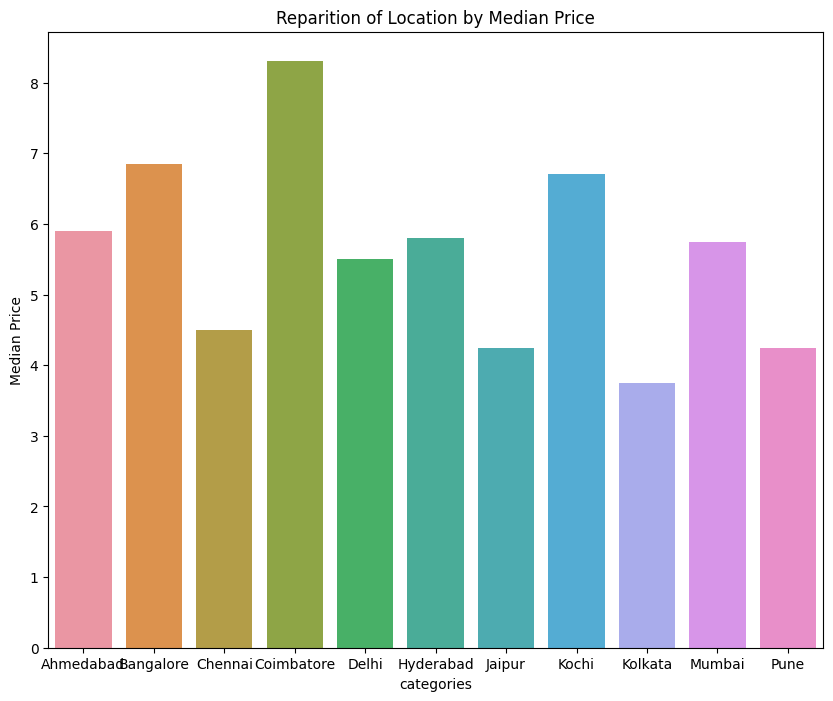

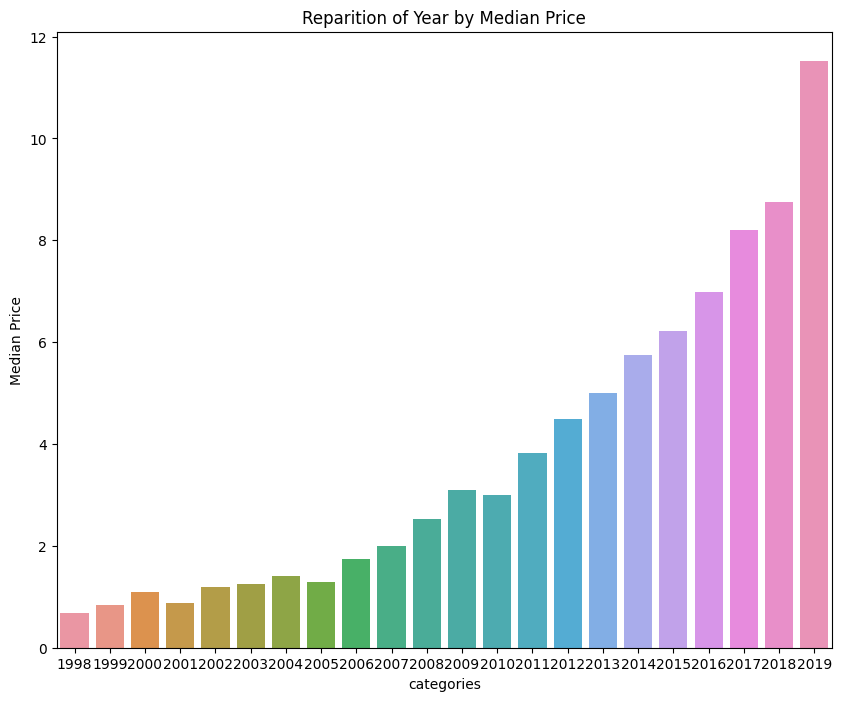

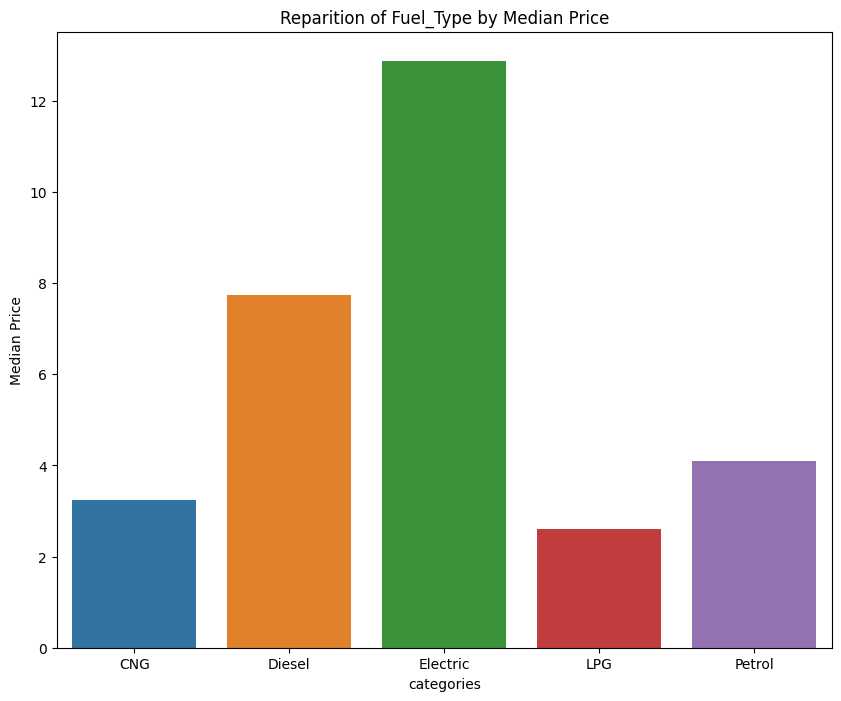

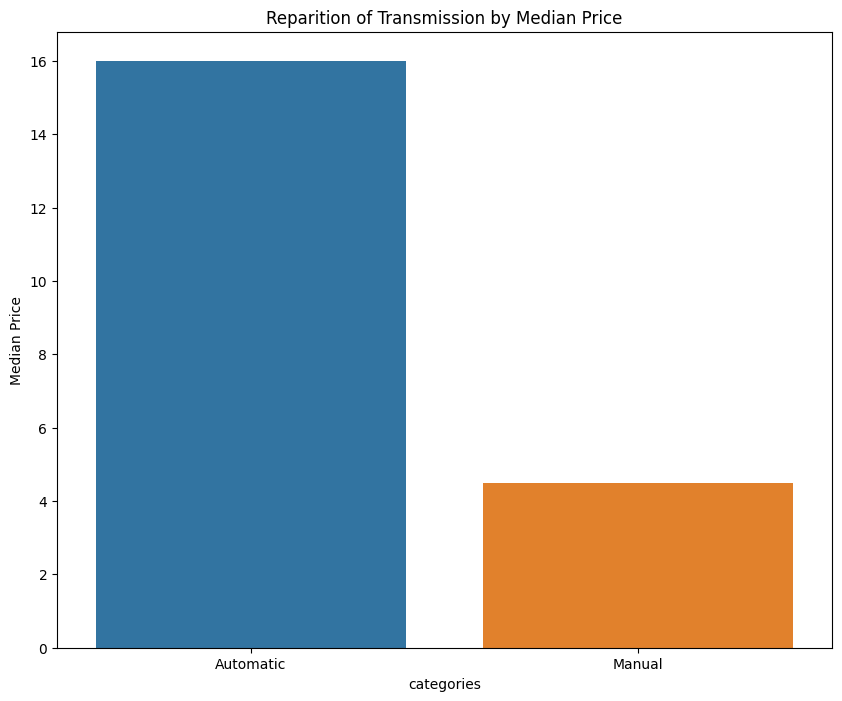

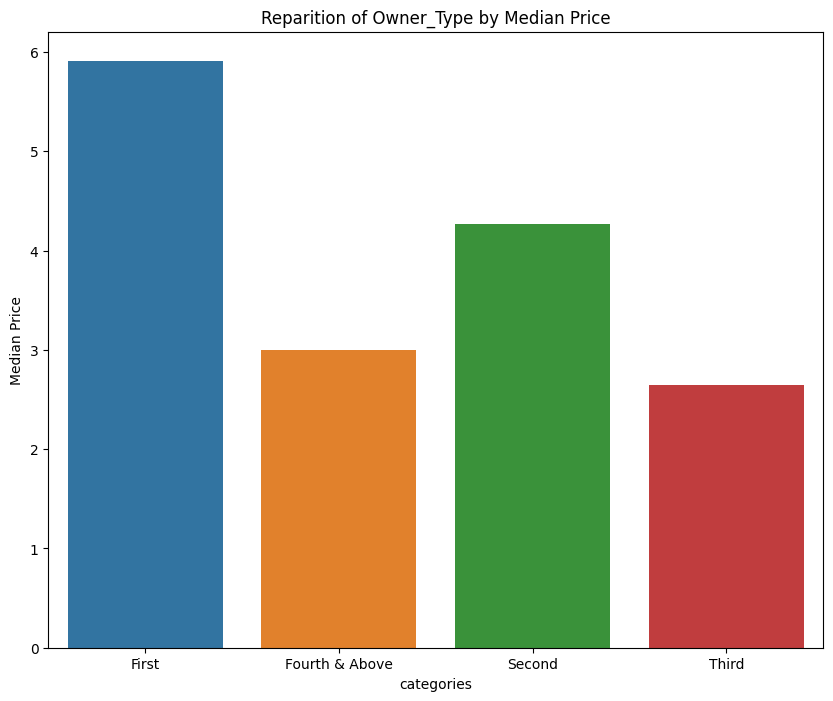

In [18]:
for var in categoricals_variables:
    plt.figure(figsize= (10,8))
    
    test = data_train[[var, "Price"]] \
       .groupby(var) \
       .agg({"Price": "median"}) \
       .reset_index()
    
    sns.barplot(x = var,y= "Price", data = test)
    plt.title(f"Reparition of {var} by Median Price")
    plt.xlabel("categories")
    plt.ylabel("Median Price")

*Summary* : 
>- More the car have had owner more it becomes cheaper
>- the automatic car are more expensive than the manual car
>- the electrics cars are the most expensives
>- throughout the years, the price increase a lot
>- Coimbatore is the city where we have the most expensives car. In the opposite, In kolkata we find the most cheaper

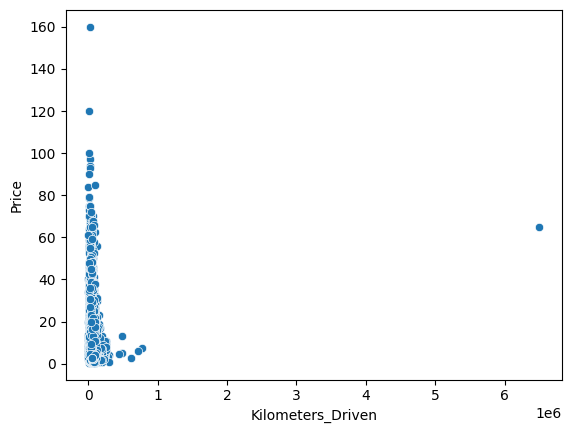

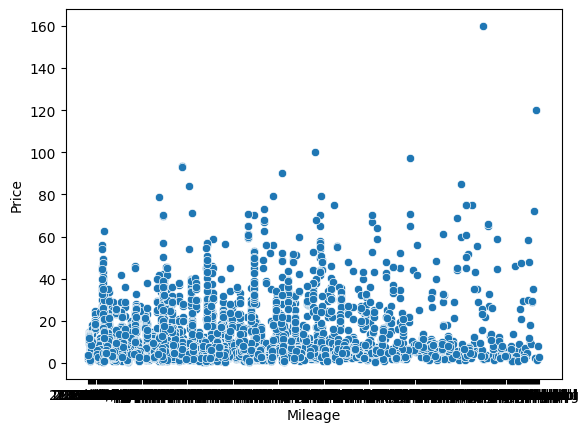

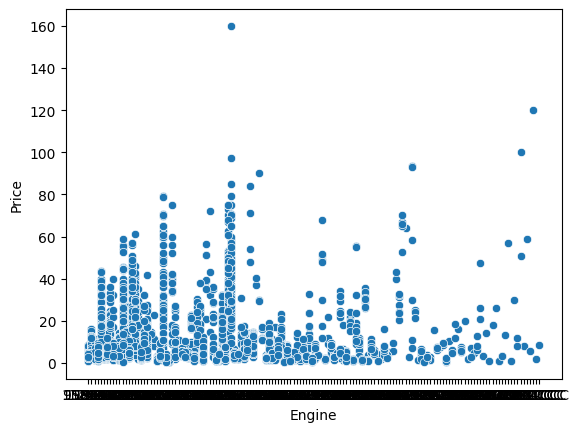

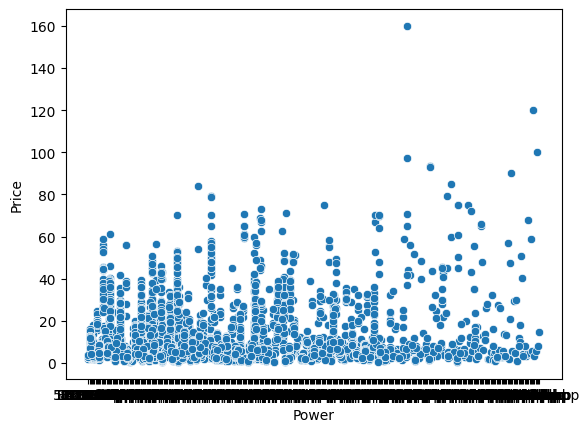

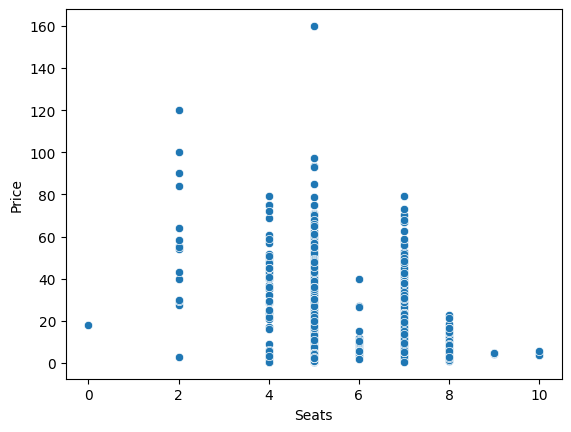

In [40]:
for var in quantitatives_variables:
    sns.scatterplot(x = data_train[var], y = data_train["Price"])
    plt.show()

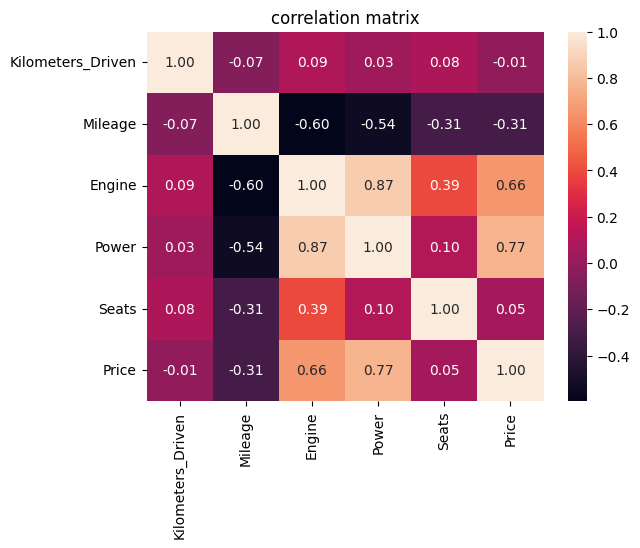

In [19]:
selected_values = quantitatives_variables + ["Price"]
correlation_matrix = data_train[selected_values].corr()

sns.heatmap(correlation_matrix, annot = True, fmt = ".2f")
plt.title("correlation matrix")
plt.show()

*Summary :*
>- We notice a strong positive correlation between the variables Power and Price and between the variables price and Engine and Power-Engine
>- we notice a negative correlation between Engine and Mileage

## 2-2) Missing values

In [7]:
# create a validation set in order to evaluate our model performances
features = data_train.drop(columns = "Price", axis = 1)
target = data_train["Price"]
data_train_bis, data_val, y_train, y_val = train_test_split(features, target,test_size=0.2,
                                                            random_state = 42)

print("data_train_bis", data_train_bis.shape, 
     "\ndata_val", data_val.shape,
     "\ny_train", y_train.shape,
     "\n y_val", y_val.shape)

data_train_bis (4815, 13) 
data_val (1204, 13) 
y_train (4815,) 
 y_val (1204,)


In [8]:
# impute values

imputer = SimpleImputer(missing_values = np.nan, strategy = "median")
data_train_quant = imputer.fit_transform(data_train_bis[quantitatives_variables])
data_val_quant = imputer.transform(data_val[quantitatives_variables])
data_test_quant = imputer.transform(data_test[quantitatives_variables])

# transformation into a dataframe form

data_train_quant = pd.DataFrame(data_train_quant, columns = quantitatives_variables )
data_val_quant = pd.DataFrame(data_val_quant, columns = quantitatives_variables )
data_test_quant = pd.DataFrame(data_test_quant, columns = quantitatives_variables )

In [9]:
data_test = data_test[data_test["Year"] != 1996]
data_test["Year"] = data_test["Year"].cat.remove_unused_categories() 
data_test["Year"].value_counts()

Year
2015    185
2016    145
2013    142
2014    128
2017    122
2011    113
2012    110
2010     65
2018     63
2009     54
2008     33
2007     23
2019     17
2006     11
2005     11
2004      4
2002      3
2003      3
2000      1
Name: count, dtype: int64

In [10]:
# categoricals variables

encoder = OneHotEncoder(sparse_output= False)

data_cat_train = encoder.fit_transform(data_train_bis[categoricals_variables])
data_cat_val = encoder.transform(data_val[categoricals_variables])
data_cat_test = encoder.transform(data_test[categoricals_variables])

variables = encoder.get_feature_names_out(categoricals_variables)

# transforming into a dataframe form
data_cat_train = pd.DataFrame(data_cat_train, columns = variables)
data_cat_val = pd.DataFrame(data_cat_val, columns = variables)
data_cat_test = pd.DataFrame(data_cat_test, columns = variables)

for var in variables:
    data_cat_train[var] = data_cat_train[var].apply(int)
    data_cat_val[var] = data_cat_val[var].apply(int)
    data_cat_test[var] = data_cat_test[var].apply(int)

In [12]:
# final dataset

final_data_train = pd.concat([data_train_quant, data_cat_train], axis = 1)
final_data_val = pd.concat([data_val_quant, data_cat_val], axis = 1)
final_data_test = pd.concat([data_test_quant, data_cat_test], axis = 1)

# record clean data
final_data_train.to_pickle("C:/Users/mayen/ML_DL_PROJECTS/CARS_PRICES/data/processed_data/data_train_clean.pkl")
final_data_val.to_pickle("C:/Users/mayen/ML_DL_PROJECTS/CARS_PRICES/data/processed_data/data_val_clean.pkl")
final_data_test.to_pickle("C:/Users/mayen/ML_DL_PROJECTS/CARS_PRICES/data/processed_data/data_test_clean.pkl")

#  3-) Machine Learning
## 3-1) Linear Regression Models (Simple Regression, Ridge and Lasso)

In [13]:
model_1 = LinearRegression()
model_1.fit(final_data_train, y_train)
y_pred_1 = model_1.predict(final_data_val)

In [14]:
print("MSE", mean_squared_error(y_val,y_pred_1 ))
print("MAE", mean_absolute_error(y_val,y_pred_1 ))
print("R2", r2_score(y_val,y_pred_1 ))

MSE 65.24269545184919
MAE 3.907720422630331
R2 0.46982801206058633


*Summary :*
>- MSE :
>- MAE :
>- R2 :

Our model do an error of approximatively 3.31 for each prediction. It explains only 47% of the variance of the cars pricing

## 3-2) Random Forest Model 1

In [15]:
model_rf1 = RandomForestRegressor(n_estimators = 500, random_state = 42)

model_rf1.fit(final_data_train, y_train)
y_pred4 = model_rf1.predict(final_data_val)

In [16]:
# evaluation 3
print("MSE", mean_squared_error(y_val,y_pred4 ))
print("MAE", mean_absolute_error(y_val,y_pred4 ))
print("R2", r2_score(y_val,y_pred4 ))

MSE 19.92417886555892
MAE 1.8845562986869162
R2 0.8380931161096835


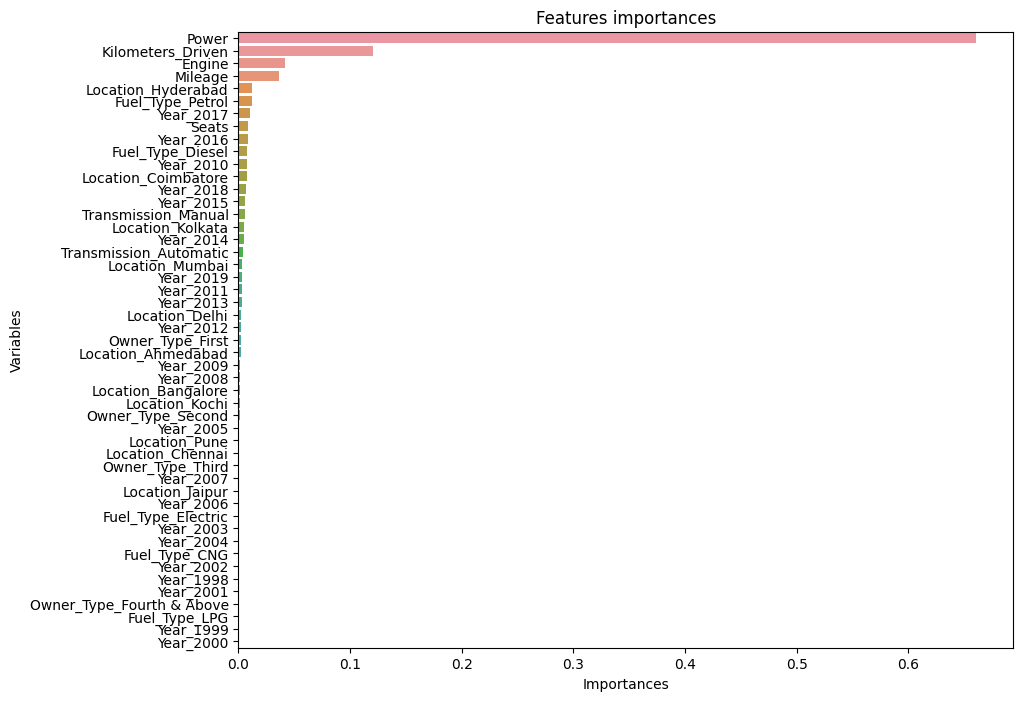

In [21]:
data_importances = pd.DataFrame({"Variables" : final_data_train.columns.to_list(),
                                "Importances": model_rf1.feature_importances_ }) \
                                .sort_values(by = "Importances", ascending = False)

plt.figure(figsize = (10,8))
sns.barplot(x = "Importances", y = "Variables", data = data_importances)
plt.xlabel("Importances")
plt.ylabel("Variables")
plt.title("Features importances")
plt.show()

## 3-3) Optimization GridSearchCV RF mode 2

In [13]:
param_grid = {"n_estimators" : [500, 1000, 1500],
               "max_features" : [3, 7, 10],
               "max_depth" : [5, 10,15]}

model_rf_s = RandomForestRegressor(random_state = 42)
Grid_model_rf = GridSearchCV(model_rf_s, param_grid = param_grid, cv = 5)
Grid_model_rf.fit(final_data_train, y_train)
print("Best parametres : ", Grid_model_rf.best_params_ )

Best parametres :  {'max_depth': 15, 'max_features': 10, 'n_estimators': 1000}


In [14]:
y_pred3 = Grid_model_rf.predict(final_data_val)
# evaluation 3
print("MSE", mean_squared_error(y_val,y_pred3 ))
print("MAE", mean_absolute_error(y_val,y_pred3 ))
print("R2", r2_score(y_val,y_pred3 ))

MSE 18.520957088288288
MAE 1.9754061948128365
R2 0.8494959080088089


In [15]:
# model saving
import joblib
joblib.dump(Grid_model_rf, "C:/Users/mayen/ML_DL_PROJECTS/CARS_PRICES/src/model/rf_model.joblib")

['C:/Users/mayen/ML_DL_PROJECTS/CARS_PRICES/src/model/rf_model.joblib']

# 4-) Partial Dependance Plot
